In [1]:
import random

import chained_filter
import fourier_flow_generator
import garch_generator
import gen_data_loader
import illiquidity_filter
import infty_filter
import len_filter
import numpy as np
import real_data_loader
import torch
import visualizer
from arch.univariate import StudentsT

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## Load Data

Here the data gets generated / prepared for the later analysis

#### Prepare Filters

In [3]:
inf_filter = infty_filter.InftyFilter()
iliq_filter = illiquidity_filter.IlliquidityFilter(
    window=20, min_jumps=2, exclude_tolerance=10
)
l_filter = len_filter.LenFilter(min_points=4000)

filter = chained_filter.ChainedFilter([inf_filter, iliq_filter, l_filter])
filter.reset_filter()

#### Load Data

In [4]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)
# fit filter for real data
filter.fit_filter(real_data)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


In [5]:
garch = garch_generator.GarchGenerator(
    p=3, q=3, distribution=StudentsT(), name="GARCH_3_3_student"
)
data_loader = gen_data_loader.GenDataLoader(cache="../data/cache")
gen_data = data_loader.get_timeseries(
    generator=garch, col_name="Adj Close", data_loader=real_loader, update_all=False
)
# filter garch data as well
filter.fit_filter(gen_data)

Cached data found at ../data/cache/time_series_GARCH_3_3_student_Adj_Close.csv.


/home/nico/edu/masterthesis/code/src/data_source/illiquidity_filter.py:36: RuntimeWarning: invalid value encountered in subtract
  np_diff = np.pad(np_data[:-1] - np_data[1:], pad_width=((1, 0), (0, 0)))


In [6]:
ff_gen = fourier_flow_generator.FourierFlowGenerator(
    learning_rate=1e-2, epochs=1000, dtype=torch.float32
)
ff_loader = gen_data_loader.GenDataLoader(cache="../data/cache")
ff_data = ff_loader.get_timeseries(
    ff_gen,
    data_loader=real_loader,
    col_name="Adj Close",
    update_all=False,
    symbols=["MSFT", "AMZN"],
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


/home/nico/edu/masterthesis/code/src/fourier_flows/fourier_flow_generator.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(price_data, dtype=self.dtype)


Epoch:          0, last loss 101370.6514,aveage_loss 101370.6514
Epoch:         10, last loss 25842.1665,aveage_loss 34564.9952
Epoch:         20, last loss 22827.6445,aveage_loss 29681.3677
Epoch:         30, last loss 17869.5744,aveage_loss 26730.7878
Epoch:         40, last loss 14640.8471,aveage_loss 24110.6535
Epoch:         50, last loss  9974.8668,aveage_loss 21709.7071
Epoch:         60, last loss  4919.3152,aveage_loss 19276.3915
Epoch:         70, last loss   496.7564,aveage_loss 16928.4135
Epoch:         80, last loss -3219.6653,aveage_loss 14643.3658
Epoch:         90, last loss -5231.4488,aveage_loss 12501.5880
Finished training!


/home/nico/edu/masterthesis/code/src/fourier_flows/fourier_flow_generator.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(price_data, dtype=self.dtype)


Epoch:          0, last loss 70724.5792,aveage_loss 70724.5792
Epoch:         10, last loss 16538.6119,aveage_loss 22330.1738
Epoch:         20, last loss 14054.9524,aveage_loss 18780.5956
Epoch:         30, last loss 12160.0039,aveage_loss 16898.2930
Epoch:         40, last loss 10404.2210,aveage_loss 15497.0972
Epoch:         50, last loss  9836.7766,aveage_loss 14470.5147
Epoch:         60, last loss  8372.1827,aveage_loss 13572.8765
Epoch:         70, last loss  6488.8236,aveage_loss 12716.0626
Epoch:         80, last loss  4785.8951,aveage_loss 11861.9931
Epoch:         90, last loss  3596.5275,aveage_loss 11015.8089
Finished training!
Stocks containing infinity : [].


In [12]:
iliq_filter.print_state()
l_filter.print_state()
filter.print_state()

Illiquidity Filter, will drop 24 columns.
Seqence lenght Filter, will drop 72 columns.
The chain filter contains the following filters: ['Infinity filter', 'Illiquidity filter', 'Seqence lenght filter']. All together will will drop 95 columns.


#### Apply Filters

In [13]:
filter.apply_filter(gen_data)
filter.apply_filter(real_data)

### Generate Plots

Map Time :0ms
Prep Time :0ms
Loop Time :5ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :5ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :1ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :0ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :0ms
Post Time :0ms
Loops Time :31ms


/home/nico/edu/masterthesis/code/src/stylized_facts/gain_loss_asymetry.py:65: RuntimeWarning: invalid value encountered in divide
  boosted_gain = boosted[0] / boosted[0].sum(axis=0)
Values less than or equal to 0 in data. Throwing out 0 or negative values
/home/nico/.cache/pypoetry/virtualenvs/synthetic-data-5lnic9a9-py3.10/lib/python3.10/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
/tmp/ipykernel_154149/312316657.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  visualizer.visualize_all(ff_data.loc[:,['MSFT', 'AMZN']], name=garch.name).figure.show()


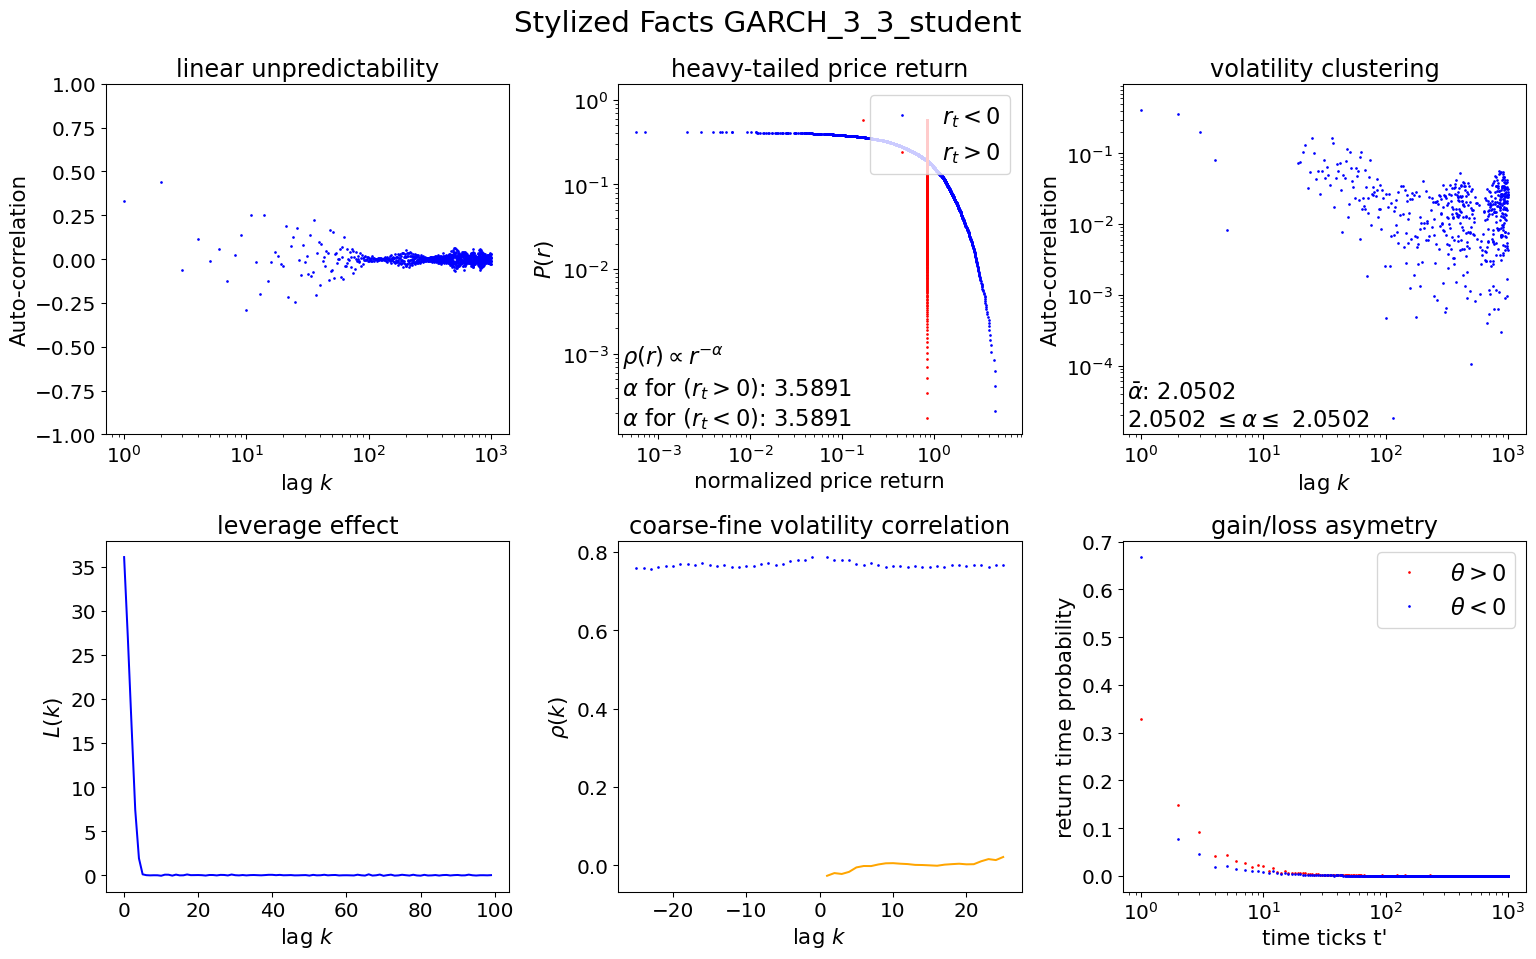

In [14]:
visualizer.visualize_all(
    ff_data.loc[:, ["MSFT", "AMZN"]], name=garch.name
).figure.show()

Map Time :0ms
Prep Time :0ms
Loop Time :5ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :5ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :1ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :0ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :0ms
Post Time :0ms
Loops Time :23ms


/tmp/ipykernel_154149/1791341777.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  visualizer.visualize_all(real_data.loc[:,["MSFT", "AMZN"]], name=garch.name).figure.show()


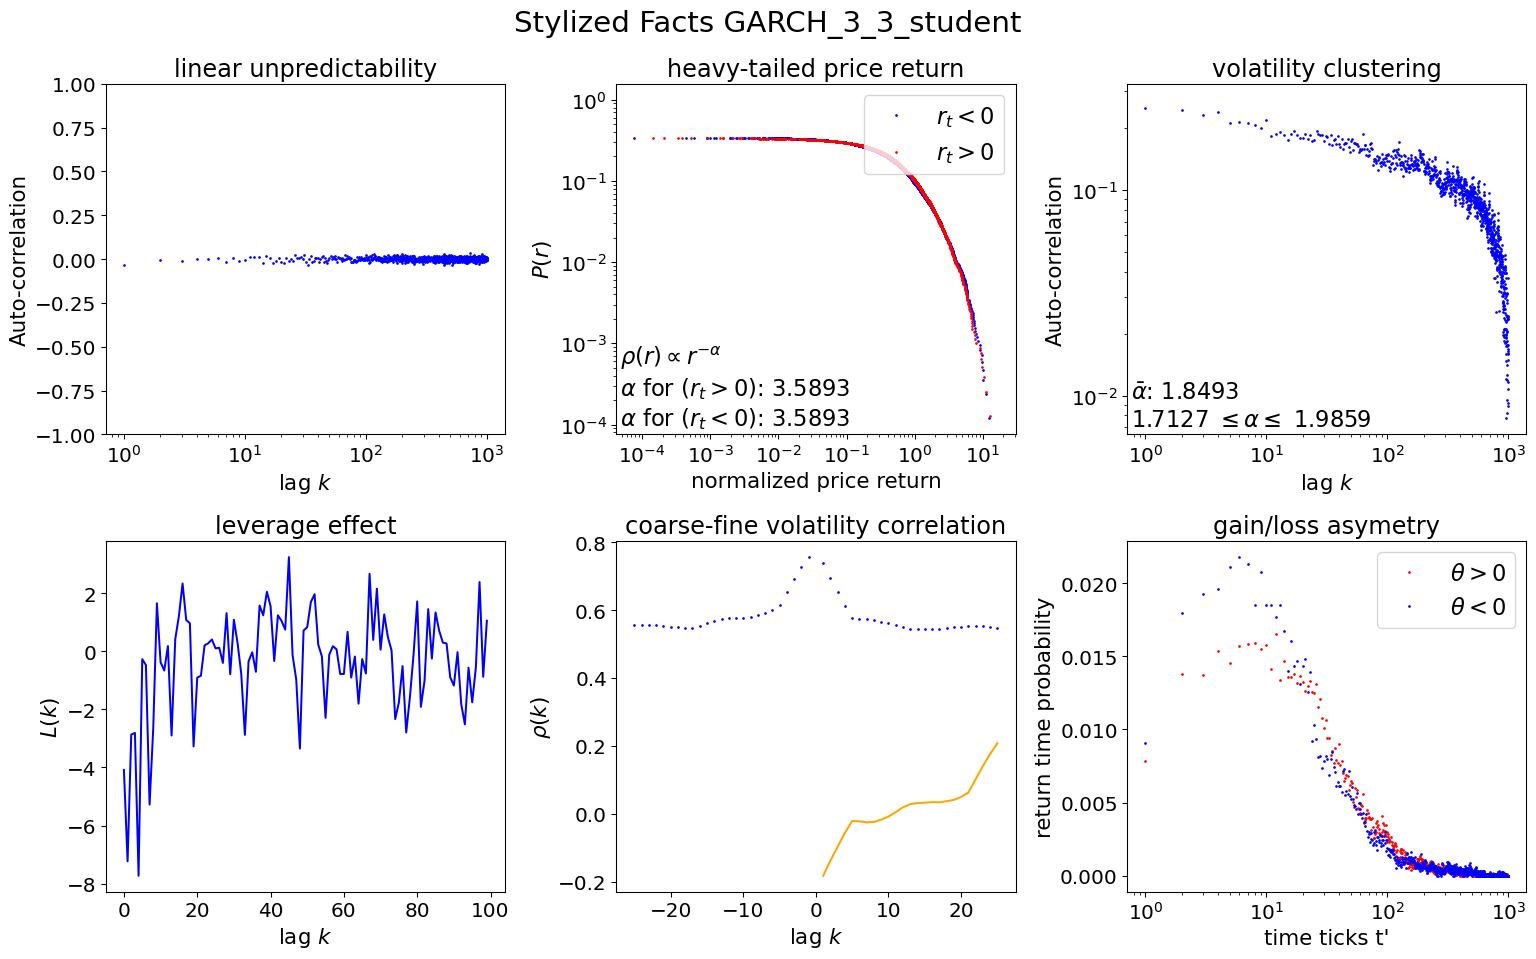

In [15]:
visualizer.visualize_all(
    real_data.loc[:, ["MSFT", "AMZN"]], name=garch.name
).figure.show()

Map Time :0ms
Prep Time :0ms
Loop Time :5ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :5ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :1ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :0ms
Post Time :0ms
Map Time :0ms
Prep Time :0ms
Loop Time :0ms
Post Time :0ms
Loops Time :26ms


/tmp/ipykernel_154149/960299146.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  visualizer.visualize_all(gen_data.loc[:,["MSFT", "AMZN"]], name=garch.name).figure.show()


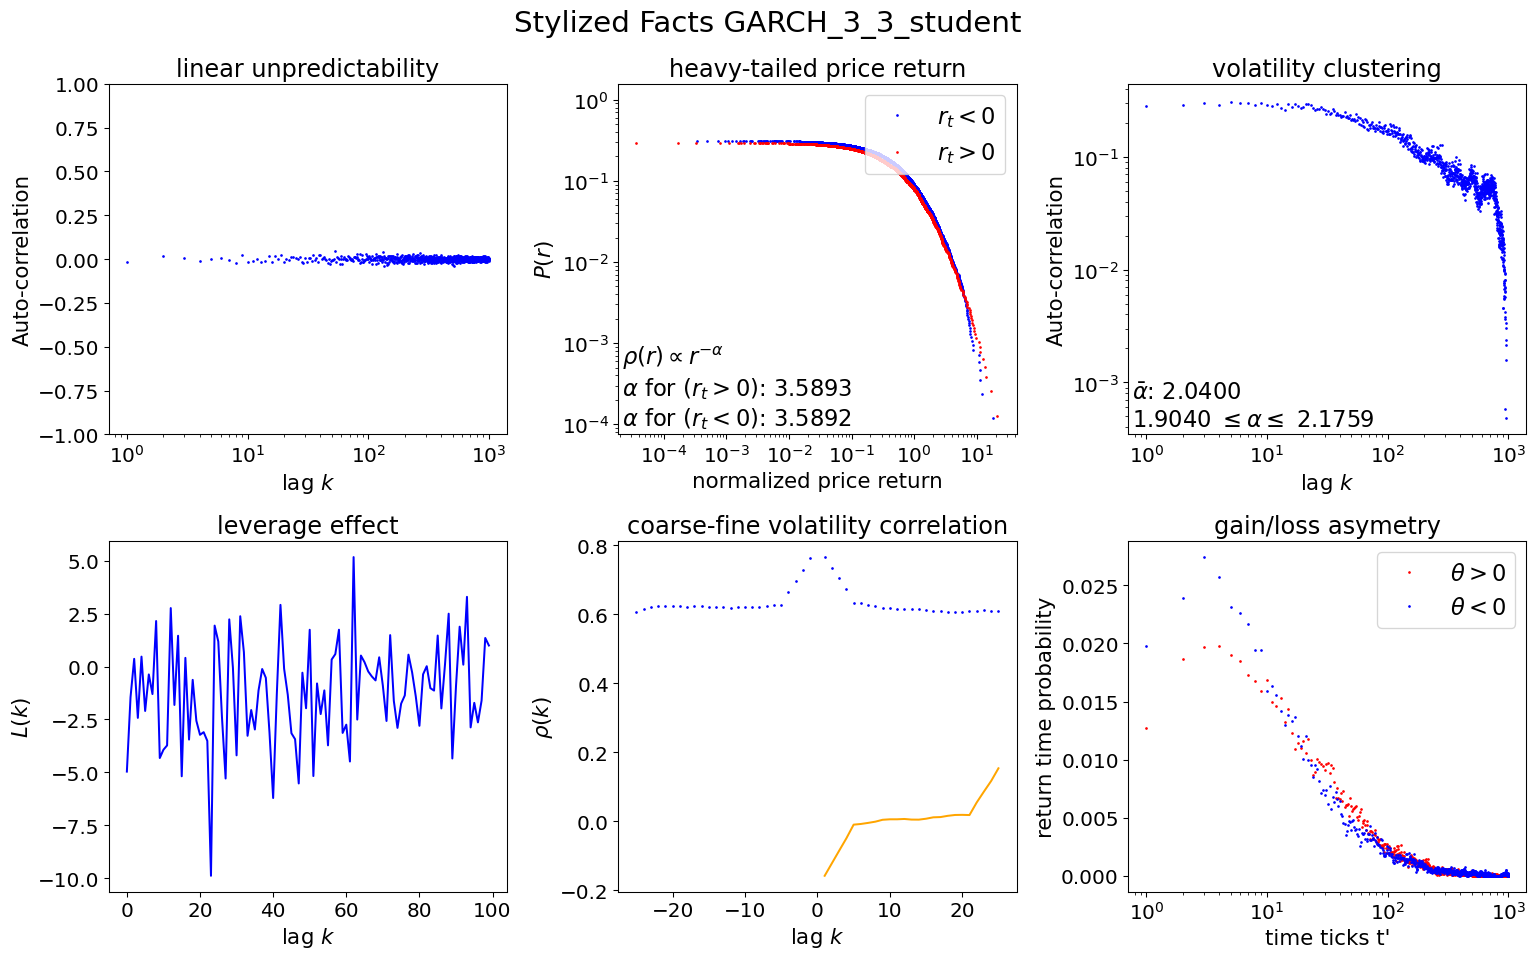

In [16]:
visualizer.visualize_all(
    gen_data.loc[:, ["MSFT", "AMZN"]], name=garch.name
).figure.show()